## Part 3: PreProcessing and Modelling

In [1]:
## We start by importing the appropriate packages which we will want to use. 
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
import warnings
from io import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split 
from sklearn import (
    linear_model, 
    preprocessing,
    tree,
    metrics
)

%matplotlib inline

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
## We Load and preview our customer_cltv dataframe from the previouse chapter 
customer_cltv = pd.read_csv('.\..\cleaned_data.csv',index_col=0)
customer_cltv.head()

,CustomerID,pfw_spent,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,Anonymous13455,1257.80,1,1,50.0,0,6,0,M,0,0,MW,high
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high
2,Anonymous4843,1052.75,2,2,96.0,0,10,0,S,1,0,W,high
3,Anonymous11225,728.10,1,1,16.0,0,1,1,No size,0,0,MW,low
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high


## Preprocessing: 

In [3]:
## Drop some error rows (no spending on the first week)
## Drop all non-repeat customers
customer_cltv_drop = customer_cltv[customer_cltv.loc[:,'fw_total_spent'] > 0] 
#customer_cltv_drop = customer_cltv_drop[customer_cltv.loc[:,'pfw_spent'] > 0]

## Drop vriables that we found to be heavily correlated with other or irrelevant
## through the previous step of EDA
## - fw_nb_items is highly correlated with fw_total_spent (c=0.94)
## - fw_nb_orders is very unbalanced (~ 95% customers only made 1 order the first week)
## - region was found to be insignificant based on several steps of statistical analysis
## - fw_purchased_accessory is logically redundant with first_item_size
customer_cltv_drop.drop(columns=['fw_nb_items', 'region', 'fw_nb_orders', 'fw_purchased_accessory'], inplace = True)

## Modify variables based on findings from EDA
## - first_order_month can be modified to be 2 categories: February-June vs rest of the year
customer_cltv_drop['first_order_feb_june'] = customer_cltv_drop['first_order_month'].apply(lambda x: x in [2, 3, 4, 5, 6])
customer_cltv_drop.drop(columns=['first_order_month'], inplace = True)

## We start by creating dummy variables for our categorical variables.
categorical_cols = ['first_item_size','first_item_price_range']
dummies_encoded = pd.get_dummies(customer_cltv_drop[categorical_cols].astype(str),drop_first=True)
customer_cltv_encoded = pd.concat([customer_cltv_drop,dummies_encoded], axis =1)
customer_cltv_encoded.drop(columns=['first_item_size','first_item_price_range'],
                   inplace = True)

customer_cltv_encoded.head(2)

,CustomerID,pfw_spent,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,first_item_size_M,first_item_size_No size,first_item_size_S,first_item_size_XL,first_item_size_XS,first_item_price_range_low,first_item_price_range_medium
0,Anonymous13455,1257.80,50.0,0,0,0,True,1,0,0,0,0,0,0
1,Anonymous2142,436.15,48.0,0,0,0,True,0,0,0,0,0,0,0


In [4]:
## We get our feature variables and target variables
X = customer_cltv_encoded.drop(columns=['CustomerID','pfw_spent'])
y = customer_cltv_encoded['pfw_spent']
print(X.shape, y.shape)

(10590, 12) (10590,)


In [5]:
## We use a scaler to scale the feature variables which are not categorical: 
cols_to_scale = ['fw_total_spent']
scaler = preprocessing.StandardScaler().fit(X[cols_to_scale])
X_scaled = scaler.transform(X[cols_to_scale])
for ind, col in enumerate(cols_to_scale):
    X[col] = X_scaled[:,ind]
X.head()

,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,first_item_size_M,first_item_size_No size,first_item_size_S,first_item_size_XL,first_item_size_XS,first_item_price_range_low,first_item_price_range_medium
0,-0.347324,0,0,0,True,1,0,0,0,0,0,0
1,-0.389530,0,0,0,True,0,0,0,0,0,0,0
2,0.623424,0,1,0,False,0,0,1,0,0,0,0
3,-1.064833,0,0,0,False,0,1,0,0,0,1,0
4,-0.347324,0,0,0,False,0,0,0,0,1,0,0


In [6]:
## We split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7942, 12) (2648, 12) (7942,) (2648,)


## I. Linear Models: 
- Ordinary Linear Regression
- Lasso, Ridge Regression - tried but don't bring benefits compared to OLS, because we find reasonable coefficient values without applying penalization.
- Elastic Net - not tried, though we would expect the same as above.

- Decision Trees
- Random Forest
- GBM
- Light GBM
- XGboost
- Adaboost
- Neural Networks

## Multiple Linear Regression

In [7]:
## We instantiate the linear Regression model and fit to the training data. 
from sklearn.linear_model import LinearRegression
rModel = linear_model.LinearRegression(normalize = False)
rModel.fit(X_train, y_train)

LinearRegression(normalize=False)

In [8]:
## We check R squared. 
print("R-squared on training data: ", rModel.score(X_train,y_train))
print("R-squared on test data: ", rModel.score(X_test,y_test))
print("Model coefficients: ", rModel.coef_)
print("Model intercept: ", rModel.intercept_)
print("Coef matrix rank: ", rModel.rank_)
print("Coef matrix singular values: ", rModel.singular_)

R-squared on training data:  0.047097923114843065
R-squared on test data:  0.03728836133894331
Model coefficients:  [ 16.37223432   2.81381363   7.5793226   -5.38992058  13.73370418
  -8.71933939 -11.79505585 -12.20649571   3.14884656 -12.55414936
  -1.83364948  -2.6997442 ]
Model intercept:  39.15268541847427
Coef matrix rank:  12
Coef matrix singular values:  [90.79428893 50.60862309 46.45052426 44.25331612 39.11514057 34.20564871
 32.20886641 31.62877756 31.09081932 24.6293075  20.09019577 12.90283844]


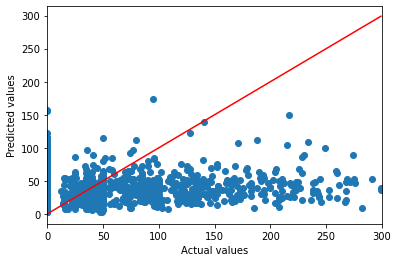

In [9]:
## We visualize the Actual values vs the predicted values. 
y_pred = rModel.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([x for x in range(0,300)],[x for x in range(0,300)], color='r')
plt.xlim(0,300)
plt.show()

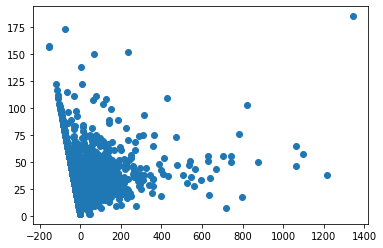

In [10]:
## Plotting Residuals
residuals = y_test - y_pred
plt.scatter(residuals,y_pred)
plt.show()

## Decision Tree Regressor:

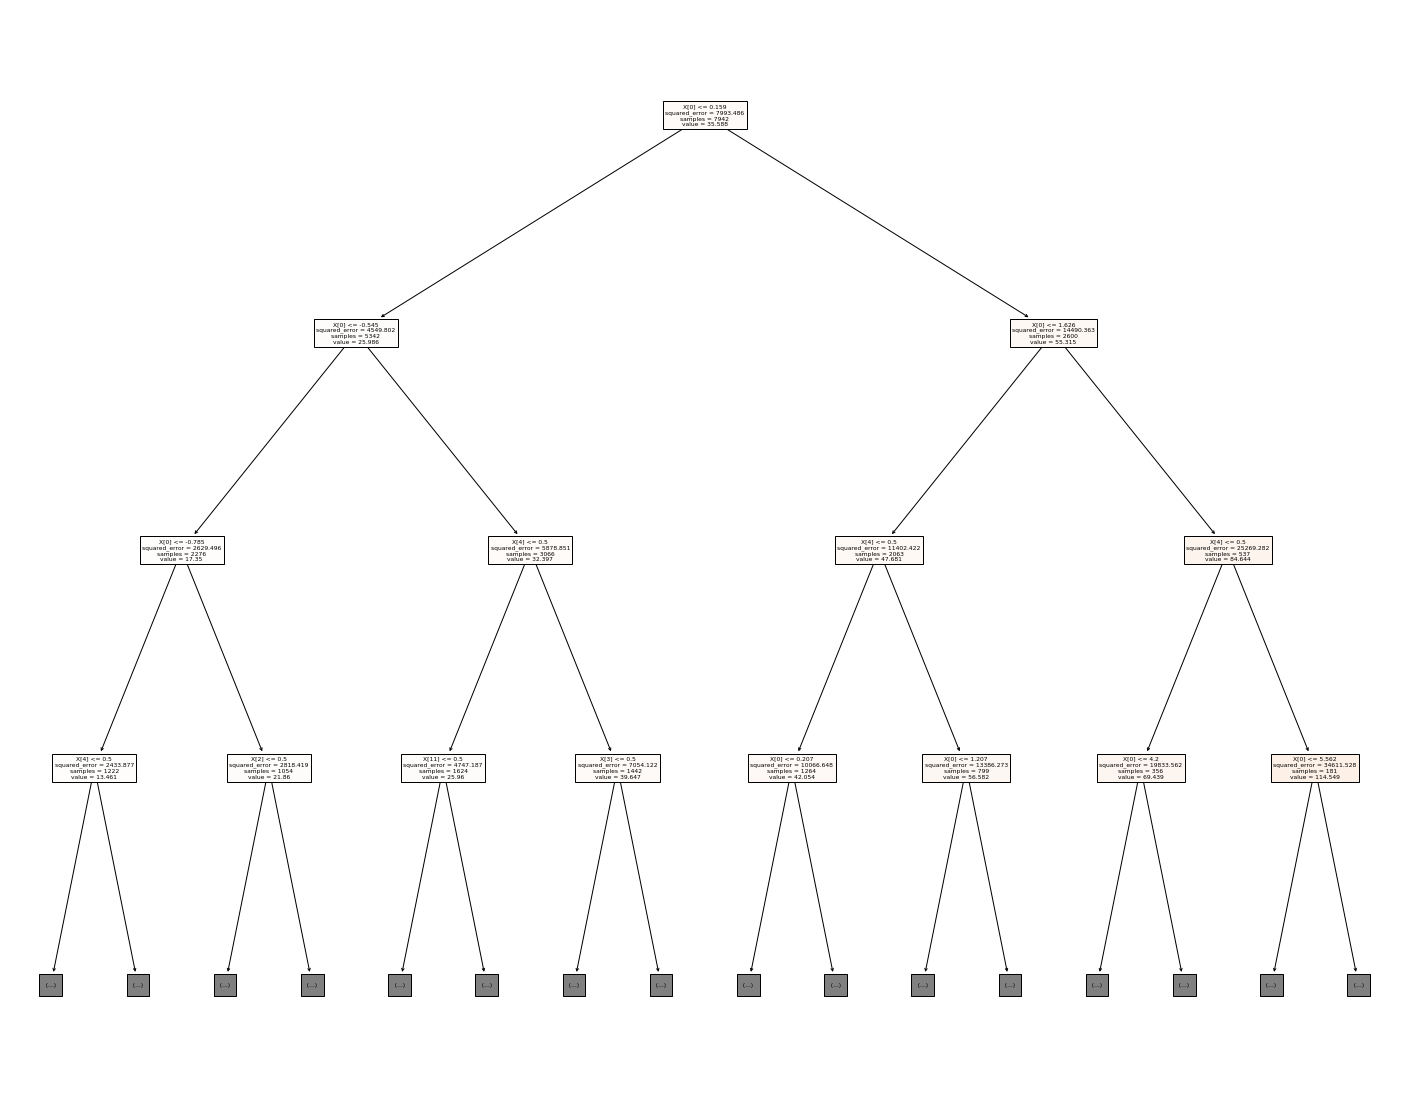

In [11]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
DT = DecisionTreeRegressor()
DT.fit(X_train,y_train)
y_pred = DT.predict(X_test)

fig = plt.figure(figsize=(25,20))
_ = plot_tree(DT,max_depth =3, filled = True)

## Random Forest Regressor

In [12]:
from sklearn.ensemble import RandomForestRegressor
RFG = RandomForestRegressor(n_estimators=100, max_depth=6)   #(n_estimators = 100, #max_depth = 10)
RFG.fit(X_train,y_train)

RandomForestRegressor(max_depth=6)

In [13]:
print("R squared for random forest regressor, on training data: ", RFG.score(X_train, y_train))
print("R squared for random forest regressor, on test data: ", RFG.score(X_test, y_test))

R squared for random forest regressor, on training data:  0.13327010354201596
R squared for random forest regressor, on test data:  0.02977234089917935


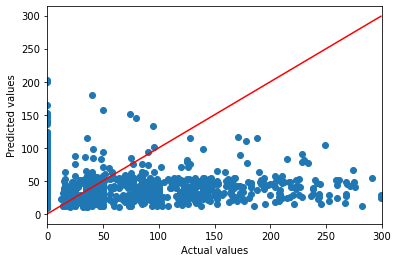

In [14]:
y_pred = RFG.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([x for x in range(0,300)],[x for x in range(0,300)], color='r')
plt.xlim(0,300)
plt.show()

## 2. Classification Models
- In the previous models, our target feature was **continuous**. We will be t

In [24]:
customer_cltv_drop[customer_cltv_drop['pfw_spent'] > 0]['pfw_spent'].count() / customer_cltv_drop['pfw_spent'].count()

0.2715769593956563

In [25]:
customer_cltv_cls = customer_cltv_drop
customer_cltv_cls['pfw_return'] = np.where(customer_cltv_cls['pfw_spent'] > 0,1,0)

customer_cltv_cls.head()

,CustomerID,pfw_spent,fw_total_spent,fw_used_coupon,first_item_size,accepts_marketing,wealthy_zip,first_item_price_range,first_order_feb_june,pfw_return
0,Anonymous13455,1257.80,50.0,0,M,0,0,high,True,1
1,Anonymous2142,436.15,48.0,0,L,0,0,high,True,1
2,Anonymous4843,1052.75,96.0,0,S,1,0,high,False,1
3,Anonymous11225,728.10,16.0,0,No size,0,0,low,False,1
4,Anonymous540,1114.75,50.0,0,XS,0,0,high,False,1


In [17]:
customer_cltv_cls['pfw_order'].describe()

count    10595.000000
mean         0.271449
std          0.444728
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: pwf_order?, dtype: float64

In [18]:
customer_cltv_cls = customer_cltv_cls.drop(columns='Spender_Type')

In [19]:
customer_cltv_cls

,CustomerID,pfw_spent,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range,pwf_order?
0,Anonymous13455,1257.80,1,1,50.0,0,6,0,M,0,0,MW,high,1
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high,1
2,Anonymous4843,1052.75,2,2,96.0,0,10,0,S,1,0,W,high,1
3,Anonymous11225,728.10,1,1,16.0,0,1,1,No size,0,0,MW,low,1
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10590,Anonymous15928,0.00,1,1,50.0,0,3,0,M,0,0,S,high,0
10591,Anonymous15929,0.00,1,1,50.0,0,12,0,M,0,1,S,high,0
10592,Anonymous15933,0.00,1,1,50.0,0,6,0,M,0,0,W,high,0
10593,Anonymous15935,0.00,1,2,90.0,1,12,0,XL,0,0,W,high,0


In [20]:
X = customer_cltv_cls.drop(columns=['CustomerID','pfw_spent','pfw_return','fw_nb_orders','fw_purchased_accessory'])
y = customer_cltv_cls['pfw_return']

In [21]:
X.head()

,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,1,50.0,0,6,M,0,0,MW,high
1,1,48.0,0,5,L,0,0,NE,high
2,2,96.0,0,10,S,1,0,W,high
3,1,16.0,0,1,No size,0,0,MW,low
4,1,50.0,0,1,XS,0,0,W,high


In [22]:
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size =0.25, random_state =246)

In [23]:
# Declare a variable called entr_model and use tree.DecisionTreeClassifier. 
entr_model = tree.DecisionTreeClassifier(criterion ='entropy', max_depth = 5, random_state=1234)

# Call fit() on entr_model
entr_model.fit(X_train, y_train) 

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred = entr_model.predict(X_test)

# Call Series on our y_pred variable with the following: pd.Series(y_pred)
y_pred = pd.Series(y_pred)

# Check out entr_model
entr_model

ValueError: could not convert string to float: 'S'

In [ ]:
# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(entr_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ["No", "Yes"]) 

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
## We can plot a confusion matrix
plot_confusion_matrix(entr_model,X_test,y_test, display_labels=['No','Yes'])
plt.show()

In [ ]:
# Run this block for model evaluation
print("Model Gini impurity model")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = 0))

## Random Forests:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
# Plug in appropriate max_depth and random_state parameters 
firstRFModel = RandomForestClassifier(max_depth =9, random_state = 1234)

# Model and fit
firstRFModel.fit(X_train,y_train)
y_pred = firstRFModel.predict(X_test)
y_pred = pd.Series(y_pred)

# Metrics 
print("RF model - max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred, pos_label = 1))
print('Recall score' , metrics.recall_score(y_test,y_pred, pos_label = 0))

plot_confusion_matrix(firstRFModel,X_test,y_test, display_labels=['No','Yes'])
plt.show()